
  0%|          | 0/5 [00:00<?, ?it/s]

               AAPL   TSLA
date                      
2010-06-29  31.8384  23.89
2010-06-30  31.2617  23.83
2010-07-01  30.8827  21.96
2010-07-02  30.6913  19.20
2010-07-06  30.9013  16.11
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 40)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               10496     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 19,050
Trainable params: 19,050
Non-trainable params: 0
_________________________________________________________________
-----------------------------------------------------------


 20%|██        | 1/5 [00:45<03:01, 45.41s/it]


 1 [-409112.56492185  -24868.97285408] [-2161636.8993] [ 39858. -18929.]



 40%|████      | 2/5 [01:39<02:23, 47.90s/it]


 2 [  16013.83466648 -449996.80615344] [-5371105.6931] [14071. 11858.]



 60%|██████    | 3/5 [02:27<01:36, 48.09s/it]


 3 [ 540720.80501613 -473839.41157893] [5205474.7419] [-20929.  18858.]



 80%|████████  | 4/5 [03:07<00:45, 45.53s/it]


 4 [ 39802.0059436  -15305.37961928] [4690662.35760001] [-10929. -20929.]



100%|██████████| 5/5 [03:46<00:00, 45.29s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


 5 [-83636.87393058 244009.94250839] [5050631.7575] [  7858. -20929.]
------------------------------------------------------------
Testing
------------------------------------------------------------



100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 0 [72026.50789392 40989.82156009] [4538336.7832] [10856. 10856.]


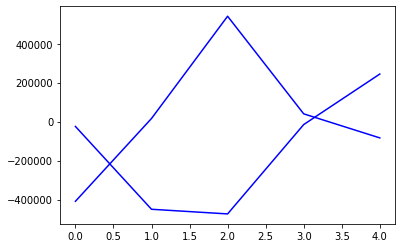

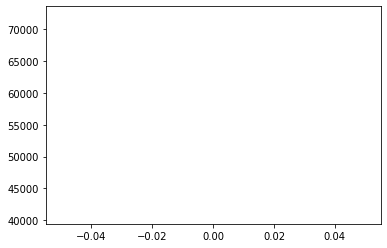

In [10]:
from environment import Market, get_ts
from model import Q_Model
from agent import Agent
from simulator import Simulator
import pandas as pd

# sampler = Single_Signal_Generator(total_timesteps=180, period_range=(10, 40), amplitude_range=(5, 80), noise_amplitude_ratio=0.5)
# filename = "Generated Signals.npy"
# sampler.build_signals(filename, 1000)
# sampler.load(filename)
# env = Market(sampler=sampler, last_n_timesteps=40, buy_cost=3.3)

# ticker=['AAPL', 'TSLA']
# # ticker=['TSLA']
# sample = get_ts(ticker)
# sample.to_csv('data/test/test_data.csv')
# import os
# print(os.getcwd())
sample = pd.read_csv('data/test/test_data.csv', index_col=0)
print(sample.head())
# print(sample.shape)
# print(sample.dtypes)
env_train = Market(sample.iloc[:1500, :], 20, 0.5)
env_test = Market(sample.iloc[1500:, :], 20, 0.5)
# env.reset()

dense_model = [
    {"type":"Reshape", "target_shape":(env_train.get_state().shape[0]*env_train.get_state().shape[1],)},
    {"type":"Dense", "units":128*env_train.get_state().shape[1]},
    {"type":"Dense", "units":32}
]
conv_model = [
    {"type":"Reshape", "target_shape":env_train.get_state().shape},
    {"type":"Conv1D", "filters":16, "kernel_size":3, "activation":"relu"},
    {"type":"Conv1D", "filters":16, "kernel_size":3, "activation":"relu"},
    {"type":"Flatten"},
    {"type":"Dense", "units":48, "activation":"relu"},
    {"type":"Dense", "units":24, "activation":"relu"}
]
gru_model = [
    {"type":"Reshape", "target_shape":env_train.get_state().shape},
    {"type":"GRU", "units":16, "return_sequences":True},
    {"type":"GRU", "units":16, "return_sequences":False},
    {"type":"Dense", "units":16, "activation":"relu"},
    # {"type":"Dense", "units":16, "activation":"relu"}
]
lstm_model = [
    {"type":"Reshape", "target_shape":env_train.get_state().shape},
    {"type":"LSTM", "units":16, "return_sequences":True},
    {"type":"LSTM", "units":16, "return_sequences":False},
    {"type":"Dense", "units":16, "activation":"relu"},
    # {"type":"Dense", "units":16, "activation":"relu"}
]

q_model = Q_Model("Dense", state_dim=env_train.get_state().shape, no_of_actions=env_train.no_of_actions, layers=dense_model, hyperparameters={"lr":0.0001})
agent = Agent(q_model, batch_size=8, discount_factor=0.995, epsilon=0.5)

no_epochs = 400

sim = Simulator(env_train, agent)
train_rewards = sim.train(no_epochs, epsilon_decay=0.997)
agent.model.save()

sim_test = Simulator(env_test, agent)
test_rewards = sim_test.test()

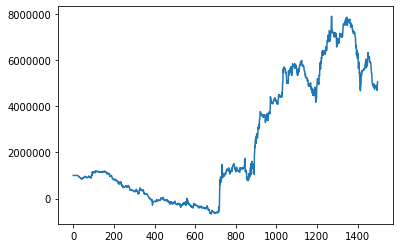

In [15]:
import matplotlib.pyplot as plt
plt.plot(env_train.portfolio_value)

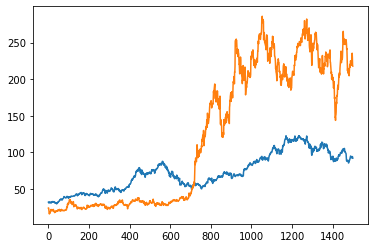

In [16]:
plt.plot(env_train.sample_2d)

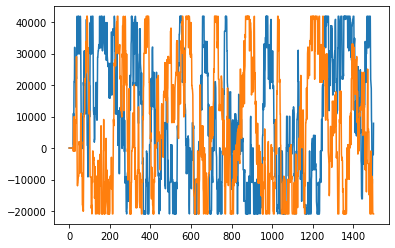

In [17]:
plt.plot(env_train.positions)

In [18]:
train_rewards

[array([-409112.56492185,  -24868.97285408]),
 array([  16013.83466648, -449996.80615344]),
 array([ 540720.80501613, -473839.41157893]),
 array([ 39802.0059436 , -15305.37961928]),
 array([-83636.87393058, 244009.94250839])]

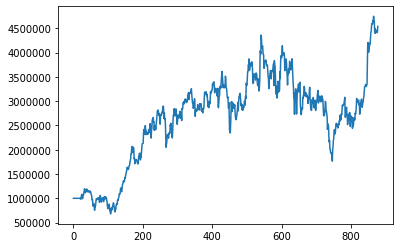

In [19]:
plt.plot(env_test.portfolio_value)

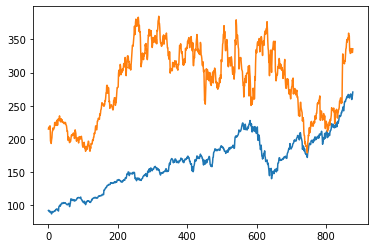

In [20]:
plt.plot(env_test.sample_2d)

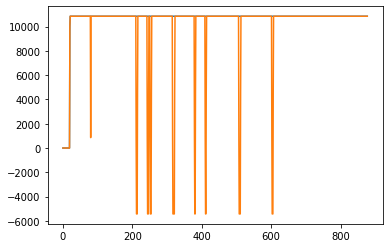

In [21]:
plt.plot(env_test.positions)

In [22]:
test_rewards

[array([72026.50789392, 40989.82156009])]